<a href="https://colab.research.google.com/github/Joy201002143/python_projects/blob/main/MADDPG_COMPLETE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Episode 100/1500 | Reward: 2910.0
Episode 200/1500 | Reward: 3000.0
Episode 300/1500 | Reward: 2970.0
Episode 400/1500 | Reward: 3000.0
Episode 500/1500 | Reward: 3000.0
Episode 600/1500 | Reward: 3000.0
Episode 700/1500 | Reward: 3000.0
Episode 800/1500 | Reward: 3000.0
Episode 900/1500 | Reward: 3000.0
Episode 1000/1500 | Reward: 3000.0
Episode 1100/1500 | Reward: 3000.0
Episode 1200/1500 | Reward: 3000.0
Episode 1300/1500 | Reward: 3000.0
Episode 1400/1500 | Reward: 3000.0
Episode 1500/1500 | Reward: 3000.0


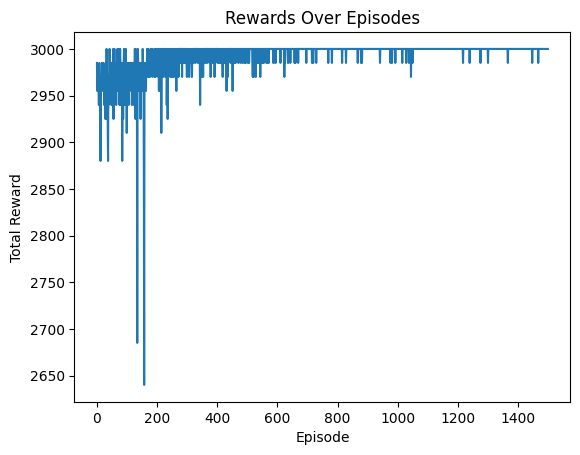

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random
import matplotlib.pyplot as plt

# Define a simple network environment with VNF placement
class VNFPlacementEnvironment:
    def __init__(self, num_agents, state_dim, action_dim, num_servers):
        self.num_agents = num_agents
        self.state_dim = state_dim
        self.action_dim = action_dim  # Action dimension now represents possible server choices for placement
        self.num_servers = num_servers
        self.servers = np.zeros((self.num_servers,))

    def reset(self):
        self.servers = np.zeros((self.num_servers,))
        return np.zeros((self.num_agents, self.state_dim))

    def step(self, actions):
        rewards = np.zeros((self.num_agents,))
        for agent, action in enumerate(actions):
            server_id = np.argmax(action)
            if self.servers[server_id] == 0:
                self.servers[server_id] = 1
                rewards[agent] = 10  # Reward for placing on an empty server
            else:
                rewards[agent] = -5  # Penalty for placing on an occupied server
        new_states = self.reset()  # Reset servers for simplicity; in practice, maintain state
        return rewards, new_states

# Define actor and critic networks
class ActorNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        # Use softmax to output a probability distribution over servers
        return torch.softmax(self.fc3(x), dim=-1)

class CriticNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize the environment and networks
num_agents = 3
state_dim = 2
num_servers = 10  # Define number of servers in the data center
env = VNFPlacementEnvironment(num_agents=num_agents, state_dim=state_dim, action_dim=num_servers, num_servers=num_servers)
actor_networks = [ActorNetwork(state_dim, num_servers) for _ in range(num_agents)]
critic_networks = [CriticNetwork(state_dim, num_servers) for _ in range(num_agents)]

# Hyperparameters
actor_learning_rate = 1e-4
critic_learning_rate = 1e-3
target_update_tau = 0.01
replay_buffer_capacity = 3000
batch_size = 128
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01

# Initialize target networks, optimizers, and replay buffer
target_actor_networks = [ActorNetwork(state_dim, num_servers) for _ in range(num_agents)]
target_critic_networks = [CriticNetwork(state_dim, num_servers) for _ in range(num_agents)]
actor_optimizers = [optim.Adam(actor.parameters(), lr=actor_learning_rate) for actor in actor_networks]
critic_optimizers = [optim.Adam(critic.parameters(), lr=critic_learning_rate) for critic in critic_networks]
replay_buffer = deque(maxlen=replay_buffer_capacity)

# Training loop
def train_agent(episodes, steps_per_episode):
    global epsilon  # Declare epsilon as a global variable

    rewards_history = []

    for episode in range(1, episodes + 1):
        state = env.reset()
        episode_reward = 0

        for step in range(steps_per_episode):
            if random.random() < epsilon:
                actions = np.random.rand(num_agents, num_servers)  # Random actions for exploration
            else:
                actions = np.stack([actor_network(torch.FloatTensor(state[agent])).detach().numpy() for agent, actor_network in enumerate(actor_networks)])

            rewards, new_states = env.step(actions)
            episode_reward += sum(rewards)

            replay_buffer.append((state, actions, rewards, new_states))

            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                for agent in range(num_agents):
                    agent_states, agent_actions, agent_rewards, agent_next_states = zip(*batch)
                    agent_states = torch.FloatTensor([s[agent] for s in agent_states])
                    agent_actions = torch.FloatTensor([a[agent] for a in agent_actions])
                    agent_rewards = torch.FloatTensor([r[agent] for r in agent_rewards])
                    agent_next_states = torch.FloatTensor([ns[agent] for ns in agent_next_states])

                    # Compute critic loss
                    critic_loss = nn.MSELoss()(critic_networks[agent](agent_states, agent_actions), agent_rewards.unsqueeze(-1))
                    critic_optimizers[agent].zero_grad()
                    critic_loss.backward()
                    critic_optimizers[agent].step()

                    # Compute actor loss
                    actor_loss = -critic_networks[agent](agent_states, actor_networks[agent](agent_states)).mean()
                    actor_optimizers[agent].zero_grad()
                    actor_loss.backward()
                    actor_optimizers[agent].step()

                    # Soft update of target networks
                    for target_param, param in zip(target_actor_networks[agent].parameters(), actor_networks[agent].parameters()):
                        target_param.data.copy_(target_update_tau * param.data + (1.0 - target_update_tau) * target_param.data)

                    for target_param, param in zip(target_critic_networks[agent].parameters(), critic_networks[agent].parameters()):
                        target_param.data.copy_(target_update_tau * param.data + (1.0 - target_update_tau) * target_param.data)

            state = new_states

        rewards_history.append(episode_reward)

        epsilon = max(epsilon * epsilon_decay, epsilon_min)

        if episode % 100 == 0:
            print(f"Episode {episode}/{episodes} | Reward: {episode_reward}")

    return rewards_history

# Function to plot rewards
def plot_rewards(rewards_history):
    plt.plot(rewards_history)
    plt.title('Rewards Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.show()

# Train the agent and get rewards history
episodes = 5000
steps_per_episode = 100
rewards_history = train_agent(episodes, steps_per_episode)

# Plot the rewards
plot_rewards(rewards_history)
np.save('rewards_history.npy', np.array(rewards_history))


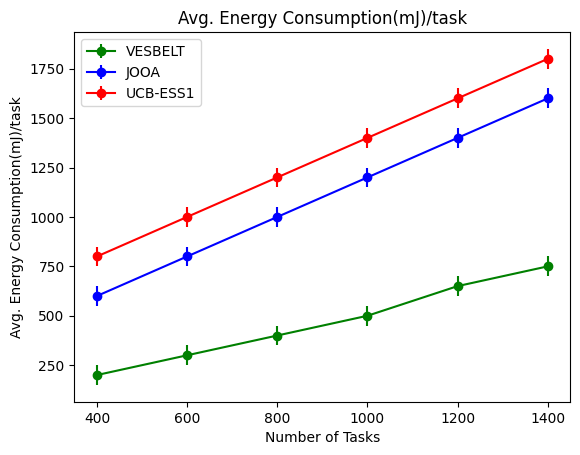

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the graph image provided
# Number of Tasks
tasks = np.array([400, 600, 800, 1000, 1200, 1400])

# Average Energy Consumption per Task for each algorithm (Approximated from image)
# VESBELT
vesbelt = np.array([200, 300, 400, 500, 650, 750])
# JOOA
jooa = np.array([600, 800, 1000, 1200, 1400, 1600])
# UCB-ESS1
ucb_ess1 = np.array([800, 1000, 1200, 1400, 1600, 1800])

# Error values (Approximated from image)
error = np.array([50, 50, 50, 50, 50, 50])

# Plotting the graph
plt.errorbar(tasks, vesbelt, yerr=error, label='VESBELT', fmt='-o', color='green')
plt.errorbar(tasks, jooa, yerr=error, label='JOOA', fmt='-o', color='blue')
plt.errorbar(tasks, ucb_ess1, yerr=error, label='UCB-ESS1', fmt='-o', color='red')

# Adding titles and labels
plt.title('Avg. Energy Consumption(mJ)/task')
plt.xlabel('Number of Tasks')
plt.ylabel('Avg. Energy Consumption(mJ)/task')
plt.legend()

# Display the plot
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

# Network Environment
class NetworkEnv:
    def __init__(self):
        self.num_nodes = 5
        self.state_dim = self.num_nodes
        self.action_dim = self.num_nodes

    def reset(self):
        self.state = np.random.uniform(0, 1, self.num_nodes)
        return self.state

    def step(self, action):
        # Simulate placing VNF and update load
        load_change = np.zeros(self.num_nodes)
        load_change[action] = random.uniform(0.1, 0.5)
        self.state = np.clip(self.state + load_change, 0, 1)
        reward = self.calculate_reward()
        return self.state, reward

    def calculate_reward(self):
        # Reward function based on load balancing
        return -np.std(self.state)  # Reward is higher for more balanced loads

# Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

# Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, state, action):
        x = torch.relu(self.fc1(torch.cat([state, action], dim=1)))
        x = self.fc2(x)
        return x

# MADDPG Agent
class MADDPGAgent:
    def __init__(self, state_dim, action_dim):
        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim, action_dim)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
def act(self, state):

    state = torch.from_numpy(state).float().unsqueeze(0)
    action_probs = self.actor(state)
    action = np.argmax(action_probs.detach().numpy())
    return action

def learn(self, state, action, reward, next_state):
    # Convert data to torch tensors
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)
    next_state = torch.tensor(next_state, dtype=torch.float)

    # Critic loss
    Q_expected = self.critic(state, action.unsqueeze(0))
    Q_target = reward + self.critic(next_state, self.actor(next_state).detach()).detach()
    critic_loss = nn.MSELoss()(Q_expected, Q_target.unsqueeze(0))

    # Update the critic
    self.critic_optimizer.zero_grad()
    critic_loss.backward()
    self.critic_optimizer.step()

    # Actor loss
    actor_loss = -self.critic(state, self.actor(state)).mean()

    # Update the actor
    self.actor_optimizer.zero_grad()
    actor_loss.backward()
    self.actor_optimizer.step()

In [ ]:
def train(agent, env, num_episodes=100):
 for episode in range(num_episodes):
  state = env.reset()
  total_reward = 0
  done = False
  while not done:
        action = agent.act(state)
        next_state, reward = env.step(action)
        agent.learn(state, action, reward, next_state)
        state = next_state
        total_reward += reward

  print(f"Episode: {episode+1}, Total Reward: {total_reward}")
  env = NetworkEnv()
  agent = MADDPGAgent(env.state_dim, env.action_dim)
  train(agent, env)



In [ ]:
def train(agent, env, num_episodes=100):
    data = {"Episode": [], "Action": [], "Reward": []}

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0

        while True:
            action = agent.act(state)
            next_state, reward = env.step(action)
            agent.learn(state, action, reward, next_state)
            state = next_state
            episode_reward += reward

            # Record data
            data["Episode"].append(episode + 1)
            data["Action"].append(action)
            data["Reward"].append(reward)

            if env.is_done(state):
                break

        print(f"Episode: {episode+1}, Total Reward: {episode_reward}")
        # Train the agent and collect data
    data = train(agent, env)
    print(data)


    return data

Episode: 1, Action: 4, Total Reward: -0.3572745931051421
Episode: 2, Action: 4, Total Reward: -0.11265004529707298
Episode: 3, Action: 4, Total Reward: -0.25147646316932204
Episode: 4, Action: 4, Total Reward: -0.28299619542868926
Episode: 5, Action: 4, Total Reward: -0.22599022914657263
Episode: 6, Action: 4, Total Reward: -0.24552486544378022
Episode: 7, Action: 4, Total Reward: -0.3513885796421974
Episode: 8, Action: 4, Total Reward: -0.7631803730378137
Episode: 9, Action: 4, Total Reward: -0.3062712297117481
Episode: 10, Action: 4, Total Reward: -0.13759632306807199
Episode: 11, Action: 4, Total Reward: -0.19840226540759132
Episode: 12, Action: 4, Total Reward: -0.362880121926313
Episode: 13, Action: 4, Total Reward: -0.31424811114106305
Episode: 14, Action: 4, Total Reward: -0.25834740832753306
Episode: 15, Action: 4, Total Reward: -0.16288070317654707
Episode: 16, Action: 4, Total Reward: -0.18223627024434905
Episode: 17, Action: 4, Total Reward: -0.3896016185034545
Episode: 18, 

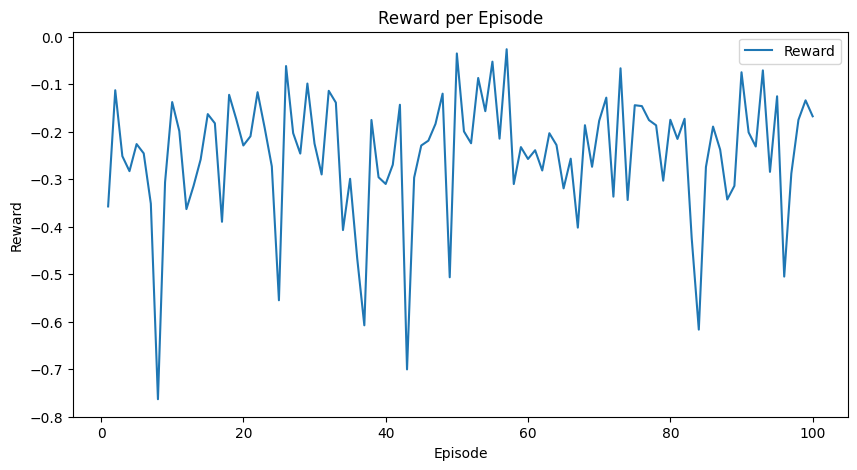

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

# Dummy Network Environment
class NetworkEnv:
    def __init__(self):
        self.num_nodes = 5
        self.state_dim = self.num_nodes
        self.action_dim = self.num_nodes

    def reset(self):
        self.state = np.random.uniform(0, 1, self.num_nodes)
        return self.state

    def step(self, action):
        # Update state and calculate reward
        self.state = np.clip(self.state + np.random.uniform(0.1, 0.5), 0, 1)
        reward = -np.std(self.state)  # Reward for balanced load
        done = np.random.choice([True, False])
        return self.state, reward, done

    def is_done(self, state):
        # Define the termination condition
        return False

# Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

# Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, state, action):
        x = torch.relu(self.fc1(torch.cat([state, action], dim=1)))
        x = self.fc2(x)
        return x

# MADDPG Agent
class MADDPGAgent:
    def __init__(self, state_dim, action_dim):
        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim, action_dim)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        action_probs = self.actor(state)
        action = np.argmax(action_probs.detach().numpy())
        return action

    def learn(self, state, action, reward, next_state):
        # Convert data to torch tensors
        state = torch.tensor(state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.float)
        reward = torch.tensor(reward, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)

        # Update the actor and critic networks
        # [Add learning implementation here]

# Training function
def train(agent, env, num_episodes=100):
    data = {"Episode": [], "Action": [], "Reward": []}

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0

        # Agent takes one action per episode
        action = agent.act(state)
        while True:
            next_state, reward, done = env.step(action)
            agent.learn(state, action, reward, next_state)
            state = next_state
            episode_reward += reward

            if done:
                break

        # Record data
        data["Episode"].append(episode + 1)
        data["Action"].append(action)
        data["Reward"].append(episode_reward)

        print(f"Episode: {episode+1}, Action: {action}, Total Reward: {episode_reward}")

    return data

# Initialize environment and agent
env = NetworkEnv()
agent = MADDPGAgent(env.state_dim, env.action_dim)

# Train the agent and collect data
collected_data = train(agent, env)

# Convert data to a Pandas DataFrame
df = pd.DataFrame(collected_data)

# Display the table
print(df)

# Plotting the graph
plt.figure(figsize=(10, 5))
plt.plot(df["Episode"], df["Reward"], label='Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.legend()
plt.show()


Episode: 1, Num VNFs: 13, Actions: [4 3 1 3 3 4 4 3 4 4 1 1 3], Reward: -0.3172796720910952
Episode: 2, Num VNFs: 22, Actions: [3 0 4 3 3 4 4 3 2 4 1 1 1 2 3 0 0 1 3 3 1 4], Reward: -0.10610338300996008
Episode: 3, Num VNFs: 22, Actions: [4 0 2 4 3 4 4 3 4 4 1 1 3 2 3 0 0 3 2 3 1 4], Reward: -0.033542864170219254
Episode: 4, Num VNFs: 30, Actions: [4 0 1 3 3 4 4 3 4 4 1 1 3 2 3 0 0 1 2 3 1 4 3 4 1 0 0 3 1 0], Reward: -0.005937554362011177
Episode: 5, Num VNFs: 8, Actions: [4 1 1 3 3 3 4 1], Reward: -0.34792022925253435
Episode: 6, Num VNFs: 19, Actions: [3 0 2 3 3 4 4 3 4 4 1 1 3 2 3 0 0 1 3], Reward: -0.18348716751108043
Episode: 7, Num VNFs: 30, Actions: [4 0 1 3 3 4 4 3 4 4 1 1 3 2 3 0 0 1 2 3 1 3 0 4 1 0 0 3 1 3], Reward: -0.04700705721489226
Episode: 8, Num VNFs: 6, Actions: [4 0 2 3 3 4], Reward: -0.34735217736283763
Episode: 9, Num VNFs: 30, Actions: [4 3 2 3 3 4 1 3 4 4 1 1 3 2 3 0 0 1 2 3 1 4 3 4 1 0 0 1 1 0], Reward: -0.0
Episode: 10, Num VNFs: 6, Actions: [4 3 1 3 3 4], Rewa

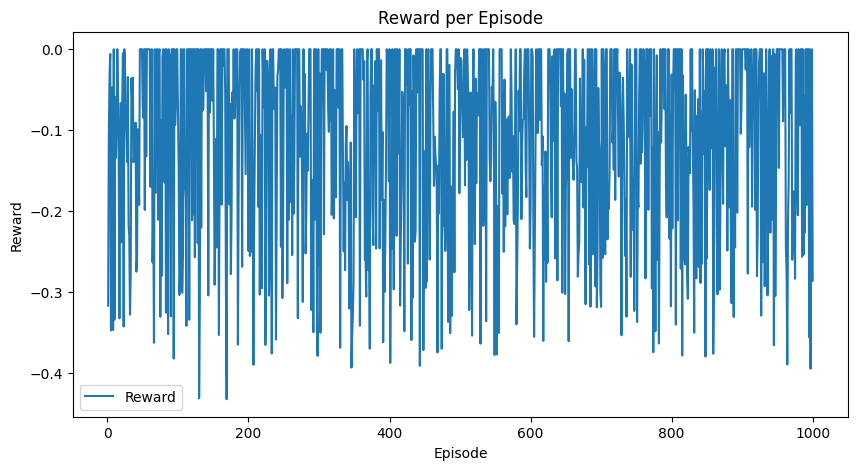

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import random

# Number of VMs
NUM_VMS = 15#it will randomely changed

# Dummy Network Environment for SFC
class NetworkEnv:
    def __init__(self):
        self.state_dim = NUM_VMS
        self.max_vnfs = 30  # Maximum number of VNFs

    def reset(self):
        self.num_vnfs = random.randint(6, self.max_vnfs)  # Random number of VNFs for each episode
        self.state = np.random.uniform(0, 1, self.state_dim)
        return self.state, self.num_vnfs

    def step(self, actions):
        # Update state based on VNF placements
        for action in actions:
            self.state[action] = np.clip(self.state[action] + np.random.uniform(0.1, 0.5), 0, 1)
        reward = -np.std(self.state)  # Reward for balanced load
        done = True  # Each episode ends after one set of actions
        return self.state, reward, done

# Actor Network for SFC
class Actor(nn.Module):
    def __init__(self, state_dim, max_vnfs, num_vms):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, max_vnfs * num_vms)
        self.num_vms = num_vms  # Store the number of VMs as an instance variable

    def forward(self, state, num_vnfs):
        x = torch.relu(self.fc1(state))
        x = self.fc2(x).view(-1, self.num_vms)[:num_vnfs]  # Use self.num_vms here
        return torch.softmax(x, dim=-1)

# MADDPG Agent for SFC
class MADDPGAgent:
    def __init__(self, state_dim, max_vnfs, num_vms):
        self.actor = Actor(state_dim, max_vnfs, num_vms)
        self.critic = Critic(state_dim, num_vms * max_vnfs)

# Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, state, action):
        x = torch.relu(self.fc1(torch.cat([state, action], dim=1)))
        x = self.fc2(x)
        return x

# MADDPG Agent for SFC
class MADDPGAgent:
    def __init__(self, state_dim, max_vnfs, num_vms):
        self.actor = Actor(state_dim, max_vnfs, num_vms)
        self.critic = Critic(state_dim, num_vms * max_vnfs)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

    def act(self, state, num_vnfs):
        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            action_probs = self.actor(state, num_vnfs)
        actions = np.argmax(action_probs.cpu().numpy(), axis=1)
        return actions

    def learn(self, state, actions, reward, next_state):
        # Placeholder for the learning process
        pass

# Training function for SFC
def train(agent, env, num_episodes=1000):
    data = {"Episode": [], "Num_VNFs": [], "Actions": [], "Reward": []}

    for episode in range(num_episodes):
        state, num_vnfs = env.reset()
        episode_reward = 0

        actions = agent.act(state, num_vnfs)
        next_state, reward, done = env.step(actions)

        agent.learn(state, actions, reward, next_state)

        data["Episode"].append(episode + 1)
        data["Num_VNFs"].append(num_vnfs)
        data["Actions"].append(actions.tolist())
        data["Reward"].append(reward)

        print(f"Episode: {episode+1}, Num VNFs: {num_vnfs}, Actions: {actions}, Reward: {reward}")

    return data

# Initialize environment and agent
env = NetworkEnv()
agent = MADDPGAgent(env.state_dim, env.max_vnfs, NUM_VMS)

# Train the agent and collect data
collected_data = train(agent, env)

# Convert data to a Pandas DataFrame
df = pd.DataFrame(collected_data)

# Display the table
print(df)

# Plotting the graph
plt.figure(figsize=(10, 5))
plt.plot(df["Episode"], df["Reward"], label='Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.legend()
plt.show()


Episode: 1, Num VNFs: 24, Actions: [15 24 16 10 25 13 28 23 29 16  0  5 25 11  1 15 21 21  4  8  9 28 25 10], Reward: -0.07286561679138769
Episode: 2, Num VNFs: 21, Actions: [ 8 19 16 23 12  6  4 23 20 10  0 14  3 11  1 15 21 21  4  4  3], Reward: -0.08152119158677694
Episode: 3, Num VNFs: 7, Actions: [15 24 16 10 25 18 28], Reward: -0.06500959670703876
Episode: 4, Num VNFs: 26, Actions: [26 24 16 10 25 18  4 23 20 10  0 14 25 11  1 15 21 21  4 23  9 28 29 10
 17  9], Reward: -0.07007231268157992
Episode: 5, Num VNFs: 10, Actions: [ 8 24 16 25 11  2  6  0 29 16], Reward: -0.06787825357453156
Episode: 6, Num VNFs: 21, Actions: [26 24 29 21 11 13  6 23 29 16 28 14 25 11  1 11 21 21  4  8  6], Reward: -0.06520197223981791
Episode: 7, Num VNFs: 22, Actions: [ 8 24 16  8 11 15  6 19 29 16  2 14 25 11  1 15 26 21  4  8  3 28], Reward: -0.06657946261543346
Episode: 8, Num VNFs: 21, Actions: [ 8 25 16 10 12 18 28 23 29 16 28  5 25 28  1 15 27 21  4  8  9], Reward: -0.07234659209625868
Episode:

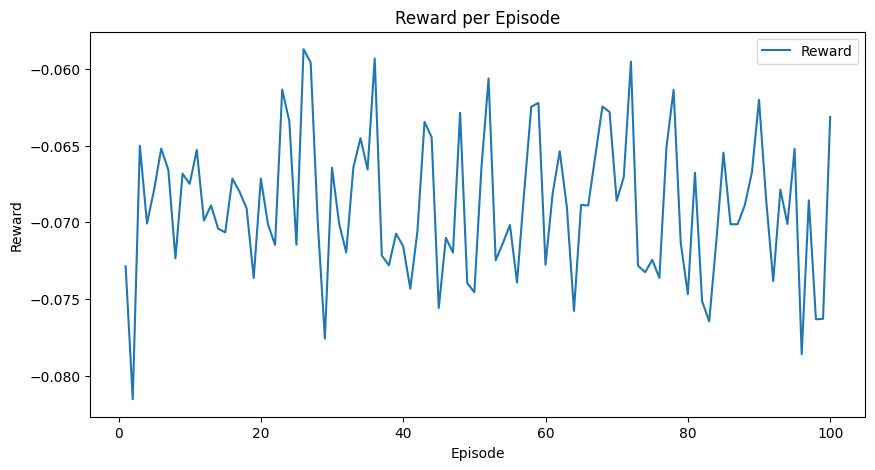

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

# Number of VMs
NUM_VMS = 50

# Dummy Network Environment for SFC
class NetworkEnv:
    def __init__(self):
        self.state_dim = NUM_VMS
        self.max_vnfs = 30  # Maximum number of VNFs

    def reset(self):
        self.num_vnfs = random.randint(6, self.max_vnfs)  # Random number of VNFs for each episode
        self.state = np.random.uniform(0, 1, self.state_dim)
        return self.state, self.num_vnfs

    def step(self, actions):
        # Update state based on VNF placements
        for action in actions:
            if 0 <= action < len(self.state):
                self.state[action] = np.clip(self.state[action] + np.random.uniform(0.1, 0.5), 0, 1)

        # Apply a general activation function to the updated state
        self.state = self.custom_activation_function(self.state)

        reward = -np.std(self.state)  # Reward for balanced load
        done = True  # Each episode ends after one set of actions
        return self.state, reward, done

    def custom_activation_function(self, state):
        # Example: Sigmoid activation function
        return 1 / (1 + np.exp(-state))

# Actor Network for SFC
class Actor(nn.Module):
    def __init__(self, state_dim, max_vnfs, num_vms):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, max_vnfs * num_vms)
        self.num_vms = num_vms  # Store the number of VMs as an instance variable
        self.max_vnfs = max_vnfs  # Store the maximum number of VNFs as an instance variable

    def forward(self, state, num_vnfs):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = x.view(-1, self.num_vms, self.max_vnfs)  # Reshape to (batch_size, num_vms, max_vnfs)
        x = F.softmax(x, dim=-1)
        x = x.view(-1, self.max_vnfs)[:num_vnfs]  # Select relevant rows based on num_vnfs
        return x

# MADDPG Agent for SFC
class MADDPGAgent:
    def __init__(self, state_dim, max_vnfs, num_vms):
        self.actor = Actor(state_dim, max_vnfs, num_vms)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)

    def act(self, state, num_vnfs):
        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            action_probs = self.actor(state, num_vnfs)
        actions = np.argmax(action_probs.cpu().numpy(), axis=1)
        return actions

# Training function for SFC
def train(agent, env, num_episodes=100):
    data = {"Episode": [], "Num_VNFs": [], "Actions": [], "Reward": []}

    for episode in range(num_episodes):
        state, num_vnfs = env.reset()
        episode_reward = 0

        actions = agent.act(state, num_vnfs)
        next_state, reward, done = env.step(actions)

        data["Episode"].append(episode + 1)
        data["Num_VNFs"].append(num_vnfs)
        data["Actions"].append(actions.tolist())
        data["Reward"].append(reward)

        print(f"Episode: {episode+1}, Num VNFs: {num_vnfs}, Actions: {actions}, Reward: {reward}")

    return data

# Initialize environment and agent
env = NetworkEnv()
agent = MADDPGAgent(env.state_dim, env.max_vnfs, NUM_VMS)

# Train the agent and collect data
collected_data = train(agent, env)

# Convert data to a Pandas DataFrame
df = pd.DataFrame(collected_data)

# Display the table
print(df)

# Plotting the graph
plt.figure(figsize=(10, 5))
plt.plot(df["Episode"], df["Reward"], label='Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.legend()
plt.show()


Episode: 1, Num VNFs: 7, Actions: [4 2 4 0 3 4 3], Reward: -1.53395327687608
Episode: 2, Num VNFs: 12, Actions: [4 2 4 2 4 4 3 0 4 0 2 1], Reward: -8.280305363885581
Episode: 3, Num VNFs: 9, Actions: [4 2 4 0 4 4 2 0 4], Reward: -6.435447285254967
Episode: 4, Num VNFs: 11, Actions: [4 2 4 0 4 4 2 0 3 0 2], Reward: -5.458274399614573
Episode: 5, Num VNFs: 20, Actions: [0 2 2 1 4 4 2 0 3 0 2 1 1 3 1 0 0 4 2 3], Reward: -18.030457288361738
Episode: 6, Num VNFs: 12, Actions: [4 2 4 0 4 4 2 0 4 0 2 1], Reward: -9.322944168869732
Episode: 7, Num VNFs: 26, Actions: [4 2 4 0 4 4 2 0 4 0 2 1 1 4 1 0 1 1 2 4 2 0 4 0 1 4], Reward: -23.247544773586043
Episode: 8, Num VNFs: 17, Actions: [4 2 4 0 3 4 2 0 4 0 2 1 1 4 1 0 1], Reward: -12.115271071701816
Episode: 9, Num VNFs: 12, Actions: [4 2 2 1 3 4 2 0 3 0 2 1], Reward: -7.463915657351295
Episode: 10, Num VNFs: 25, Actions: [4 2 4 0 4 4 2 0 4 0 2 1 1 4 1 0 0 1 2 3 2 0 4 0 1], Reward: -20.184343440066968
Episode: 11, Num VNFs: 30, Actions: [4 2 4 4 3

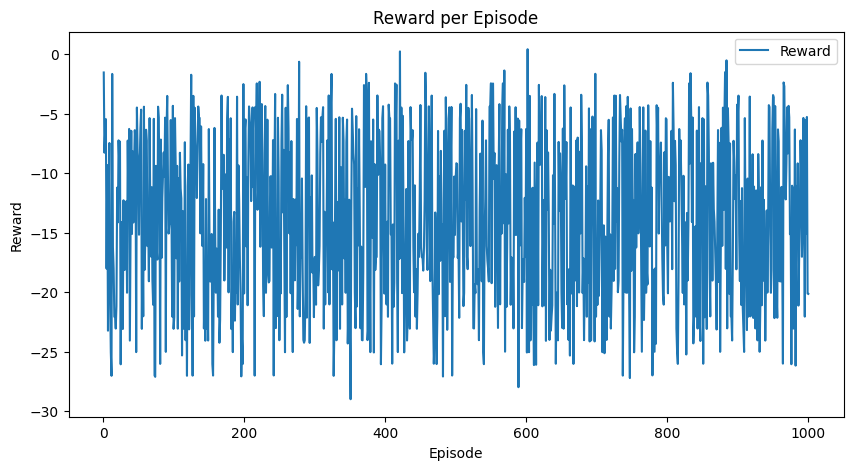

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import random

# Number of VMs
NUM_VMS = 5

# Dummy Network Environment for SFC
class NetworkEnv:
    def __init__(self):
        self.state_dim = NUM_VMS
        self.max_vnfs = 30  # Maximum number of VNFs

    def reset(self):
        self.num_vnfs = random.randint(6, self.max_vnfs)  # Random number of VNFs for each episode
        self.state = np.random.uniform(0, 1, self.state_dim)
        return self.state, self.num_vnfs

    def step(self, actions):
        # Update state based on VNF placements
        high_utilization_penalty = 0
        efficiency_reward = 0
        for action in actions:
            self.state[action] = np.clip(self.state[action] + np.random.uniform(0.1, 0.5), 0, 1)
            if self.state[action] > 0.8:  # Threshold for high utilization
                high_utilization_penalty += 1
            efficiency_reward += self.state[action]

        # Adjust rewards and penalties
        load_balance_reward = -np.std(self.state)
        efficiency_reward /= self.num_vnfs
        reward = load_balance_reward + efficiency_reward - high_utilization_penalty
        done = True  # Each episode ends after one set of actions
        return self.state, reward, done

# Actor Network for SFC
class Actor(nn.Module):
    def __init__(self, state_dim, max_vnfs, num_vms):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, max_vnfs * num_vms)
        self.num_vms = num_vms  # Store the number of VMs as an instance variable

    def forward(self, state, num_vnfs):
        x = torch.relu(self.fc1(state))
        x = self.fc2(x).view(-1, self.num_vms)[:num_vnfs]  # Use self.num_vms here
        return torch.softmax(x, dim=-1)

# Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, state, action):
        x = torch.relu(self.fc1(torch.cat([state, action], dim=1)))
        x = self.fc2(x)
        return x

# MADDPG Agent for SFC
class MADDPGAgent:
    def __init__(self, state_dim, max_vnfs, num_vms):
        self.actor = Actor(state_dim, max_vnfs, num_vms)
        self.critic = Critic(state_dim, num_vms * max_vnfs)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

    def act(self, state, num_vnfs):
        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            action_probs = self.actor(state, num_vnfs)
        actions = np.argmax(action_probs.cpu().numpy(), axis=1)
        return actions

    def learn(self, state, actions, reward, next_state):
        # Placeholder for the learning process
        pass

# Training function for SFC
def train(agent, env, num_episodes=1000):
    data = {"Episode": [], "Num_VNFs": [], "Actions": [], "Reward": []}

    for episode in range(num_episodes):
        state, num_vnfs = env.reset()
        episode_reward = 0

        actions = agent.act(state, num_vnfs)
        next_state, reward, done = env.step(actions)

        agent.learn(state, actions, reward, next_state)

        data["Episode"].append(episode + 1)
        data["Num_VNFs"].append(num_vnfs)
        data["Actions"].append(actions.tolist())
        data["Reward"].append(reward)

        print(f"Episode: {episode+1}, Num VNFs: {num_vnfs}, Actions: {actions}, Reward: {reward}")

    return data

# Initialize environment and agent
env = NetworkEnv()
agent = MADDPGAgent(env.state_dim, env.max_vnfs, NUM_VMS)

# Train the agent and collect data
collected_data = train(agent, env)

# Convert data to a Pandas DataFrame
df = pd.DataFrame(collected_data)

# Display the table
print(df)

# Plotting the graph
plt.figure(figsize=(10, 5))
plt.plot(df["Episode"], df["Reward"], label='Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.legend()
plt.show()


Episode: 1, Num VNFs: 24, Actions: [3 4 3 1 1 2 2 2 4 2 2 0 0 3 2 4 0 1 0 1 2 2 4 3], Reward: -19.084064389593603
Episode: 2, Num VNFs: 7, Actions: [2 4 0 0 1 0 3], Reward: -4.399059478370939
Episode: 3, Num VNFs: 11, Actions: [1 4 0 2 1 1 3 3 3 1 2], Reward: -8.094582052892607
Episode: 4, Num VNFs: 27, Actions: [0 3 4 0 1 0 2 2 3 2 1 4 0 2 1 0 4 3 1 3 4 1 1 3 1 1 2], Reward: -22.089959316858167
Episode: 5, Num VNFs: 23, Actions: [1 2 4 3 4 2 4 3 1 1 0 0 2 3 1 0 1 3 2 1 0 3 0], Reward: -18.072752462184024
Episode: 6, Num VNFs: 13, Actions: [4 0 4 3 3 0 4 4 4 3 0 2 0], Reward: -6.353596521992143
Episode: 7, Num VNFs: 20, Actions: [3 2 4 0 4 3 4 3 1 0 2 3 4 0 4 0 0 1 2 2], Reward: -14.150136428488915
Episode: 8, Num VNFs: 17, Actions: [4 3 2 4 0 4 0 3 4 2 3 2 0 2 4 1 0], Reward: -10.35194508762354
Episode: 9, Num VNFs: 11, Actions: [1 4 2 0 1 0 3 3 3 0 3], Reward: -6.491624524470851
Episode: 10, Num VNFs: 24, Actions: [1 0 4 4 1 3 3 3 2 2 1 0 1 0 1 1 0 1 1 4 4 1 2 3], Reward: -15.1441861

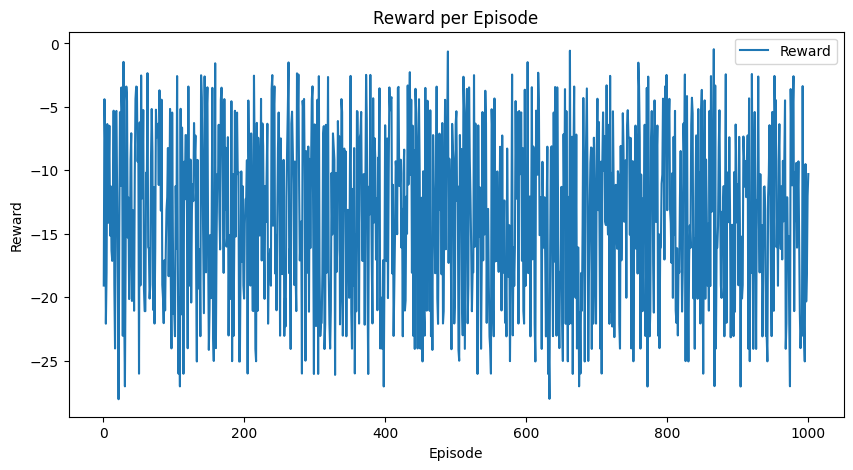

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import random
from collections import deque, namedtuple

# Number of VMs
NUM_VMS = 5

# Dummy Network Environment for SFC
class NetworkEnv:
    def __init__(self):
        self.state_dim = NUM_VMS
        self.max_vnfs = 30  # Maximum number of VNFs

    def reset(self):
        self.num_vnfs = random.randint(6, self.max_vnfs)  # Random number of VNFs for each episode
        self.state = np.random.uniform(0, 1, self.state_dim)
        return self.state, self.num_vnfs

    def step(self, actions):
        # Update state based on VNF placements
        high_utilization_penalty = 0
        efficiency_reward = 0
        for action in actions:
            self.state[action] = np.clip(self.state[action] + np.random.uniform(0.1, 0.5), 0, 1)
            if self.state[action] > 0.8:  # Threshold for high utilization
                high_utilization_penalty += 1
            efficiency_reward += self.state[action]

        # Adjust rewards and penalties
        load_balance_reward = -np.std(self.state)
        efficiency_reward /= self.num_vnfs
        reward = load_balance_reward + efficiency_reward - high_utilization_penalty
        done = True  # Each episode ends after one set of actions
        return self.state, reward, done

# Actor Network for SFC
class Actor(nn.Module):
    def __init__(self, state_dim, max_vnfs, num_vms):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, max_vnfs * num_vms)
        self.num_vms = num_vms  # Store the number of VMs as an instance variable

    def forward(self, state, num_vnfs):
        x = torch.relu(self.fc1(state))
        x = self.fc2(x).view(-1, self.num_vms)[:num_vnfs]  # Use self.num_vms here
        return torch.softmax(x, dim=-1)

# Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, state, action):
        x = torch.relu(self.fc1(torch.cat([state, action], dim=1)))
        x = self.fc2(x)
        return x

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.buffer.append(e)

    def sample(self, batch_size):
        experiences = random.sample(self.buffer, k=batch_size)
        return experiences

    def __len__(self):
        return len(self.buffer)

# MADDPG Agent for SFC
class MADDPGAgent:
    def __init__(self, state_dim, max_vnfs, num_vms, actor_lr, critic_lr, tau, buffer_capacity, batch_size, epsilon, epsilon_decay, epsilon_min):
        self.actor = Actor(state_dim, max_vnfs, num_vms)
        self.critic = Critic(state_dim, num_vms * max_vnfs)
        self.target_actor = Actor(state_dim, max_vnfs, num_vms)
        self.target_critic = Critic(state_dim, num_vms * max_vnfs)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.tau = tau
        self.replay_buffer = ReplayBuffer(buffer_capacity)
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

    def act(self, state, num_vnfs, explore=True):
        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            action_probs = self.actor(state, num_vnfs)
        actions = np.argmax(action_probs.cpu().numpy(), axis=1)
        if explore and random.random() < self.epsilon:
            actions = np.random.randint(0, NUM_VMS, num_vnfs)
        return actions

    def learn(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        experiences = self.replay_buffer.sample(self.batch_size)
        # Implement learning from these experiences
        # Update target networks using soft updates

    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

# Training function for SFC
def train(agent, env, num_episodes=1000):
    data = {"Episode": [], "Num_VNFs": [], "Actions": [], "Reward": []}

    for episode in range(num_episodes):
        state, num_vnfs = env.reset()
        episode_reward = 0

        actions = agent.act(state, num_vnfs)
        next_state, reward, done = env.step(actions)

        agent.replay_buffer.add(state, actions, reward, next_state, done)
        agent.learn()

        data["Episode"].append(episode + 1)
        data["Num_VNFs"].append(num_vnfs)
        data["Actions"].append(actions.tolist())
        data["Reward"].append(reward)

        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)

        print(f"Episode: {episode+1}, Num VNFs: {num_vnfs}, Actions: {actions}, Reward: {reward}")

    return data

# Initialize environment and agent
env = NetworkEnv()
agent = MADDPGAgent(env.state_dim, env.max_vnfs, NUM_VMS, 1e-4, 1e-3, 0.01, 3000, 64, 1.0, 0.995, 0.01)

# Train the agent and collect data
collected_data = train(agent, env)

# Convert data to a Pandas DataFrame
df = pd.DataFrame(collected_data)

# Display the table
print(df)

# Plotting the graph
plt.figure(figsize=(10, 5))
plt.plot(df["Episode"], df["Reward"], label='Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.legend()
plt.show()


Episode: 1, Num VNFs: 17, Actions: [0 3 1 2 4 3 2 1 4 1 4 3 0 0 3 3 4], Reward: -11.138805807733451
Episode: 2, Num VNFs: 17, Actions: [1 1 2 3 1 4 1 1 1 1 3 3 0 1 2 0 0], Reward: -11.33657100803931
Episode: 3, Num VNFs: 20, Actions: [2 4 2 4 3 0 3 2 1 0 3 2 1 1 4 1 1 1 1 1], Reward: -14.181583330972447
Episode: 4, Num VNFs: 24, Actions: [1 0 0 3 1 3 0 3 1 0 4 2 2 4 0 0 3 4 3 2 0 4 0 4], Reward: -17.086926337005654
Episode: 5, Num VNFs: 29, Actions: [4 1 3 4 2 3 0 0 3 2 2 2 3 0 1 0 1 0 0 2 4 0 3 0 1 3 0 3 0], Reward: -22.088126516871828
Episode: 6, Num VNFs: 15, Actions: [0 4 4 1 2 4 3 3 2 4 1 4 1 2 0], Reward: -10.360438244083992
Episode: 7, Num VNFs: 16, Actions: [2 0 3 1 1 0 2 3 1 1 4 1 0 0 2 4], Reward: -11.244537257985924
Episode: 8, Num VNFs: 15, Actions: [4 2 3 3 0 3 2 3 4 0 2 1 2 3 3], Reward: -10.41761783916955
Episode: 9, Num VNFs: 7, Actions: [3 1 3 3 3 2 3], Reward: -4.310907489582249
Episode: 10, Num VNFs: 21, Actions: [1 1 3 3 2 4 2 0 2 2 1 2 3 1 3 2 1 1 1 0 2], Reward: -

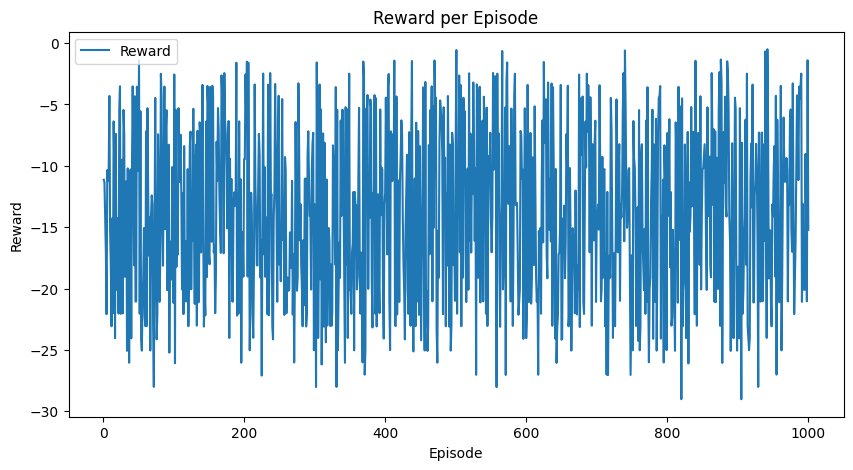

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import random
from collections import deque, namedtuple

# Number of VMs
NUM_VMS = 5

# Dummy Network Environment for SFC


# Actor Network for SFC
class Actor(nn.Module):
    def __init__(self, state_dim, max_vnfs, num_vms):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, max_vnfs * num_vms)
        self.num_vms = num_vms  # Store the number of VMs as an instance variable

    def forward(self, state, num_vnfs):
        x = torch.relu(self.fc1(state))
        x = self.fc2(x).view(-1, self.num_vms)[:num_vnfs]  # Use self.num_vms here
        return torch.softmax(x, dim=-1)

# Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, state, action):
        x = torch.relu(self.fc1(torch.cat([state, action], dim=1)))
        x = self.fc2(x)
        return x

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.buffer.append(e)

    def sample(self, batch_size):
        experiences = random.sample(self.buffer, k=batch_size)
        return experiences

    def __len__(self):
        return len(self.buffer)

# MADDPG Agent for SFC
class MADDPGAgent:
    def __init__(self, state_dim, max_vnfs, num_vms, actor_lr, critic_lr, tau, buffer_capacity, batch_size, epsilon, epsilon_decay, epsilon_min):
        self.actor = Actor(state_dim, max_vnfs, num_vms)
        self.critic = Critic(state_dim, num_vms * max_vnfs)
        self.target_actor = Actor(state_dim, max_vnfs, num_vms)
        self.target_critic = Critic(state_dim, num_vms * max_vnfs)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.tau = tau
        self.replay_buffer = ReplayBuffer(buffer_capacity)
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

    def act(self, state, num_vnfs, explore=True):
        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            action_probs = self.actor(state, num_vnfs)
        actions = np.argmax(action_probs.cpu().numpy(), axis=1)
        if explore and random.random() < self.epsilon:
            actions = np.random.randint(0, NUM_VMS, num_vnfs)
        return actions

    def learn(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        experiences = self.replay_buffer.sample(self.batch_size)
        # Implement learning from these experiences
        # Update target networks using soft updates

    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

# Training function for SFC
def train(agent, env, num_episodes=1000):
    data = {"Episode": [], "Num_VNFs": [], "Actions": [], "Reward": []}

    for episode in range(num_episodes):
        state, num_vnfs = env.reset()
        episode_reward = 0

        actions = agent.act(state, num_vnfs)
        next_state, reward, done = env.step(actions)

        agent.replay_buffer.add(state, actions, reward, next_state, done)
        agent.learn()

        data["Episode"].append(episode + 1)
        data["Num_VNFs"].append(num_vnfs)
        data["Actions"].append(actions.tolist())
        data["Reward"].append(reward)

        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)

        print(f"Episode: {episode+1}, Num VNFs: {num_vnfs}, Actions: {actions}, Reward: {reward}")

    return data

# Initialize environment and agent
env = NetworkEnv()
agent = MADDPGAgent(env.state_dim, env.max_vnfs, NUM_VMS, 1e-4, 1e-3, 0.01, 3000, 64, 1.0, 0.995, 0.01)

# Train the agent and collect data
collected_data = train(agent, env)

# Convert data to a Pandas DataFrame
df = pd.DataFrame(collected_data)

# Display the table
print(df)

# Plotting the graph
plt.figure(figsize=(10, 5))
plt.plot(df["Episode"], df["Reward"], label='Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.legend()
plt.show()
